Processing file: 000.mat
Processing file: 001.mat
Processing file: 002.mat
Processing file: 003.mat
Processing file: 004.mat
Processing file: 005.mat
Processing file: 006.mat
Processing file: 007.mat
Processing file: 008.mat
Processing file: 009.mat
Processing file: 010.mat
Processing file: 011.mat
Processing file: 012.mat
Processing file: 013.mat
Processing file: 014.mat
Processing file: 015.mat
Processing file: 016.mat
Processing file: 017.mat
Processing file: 018.mat
Processing file: 019.mat
Processing file: 020.mat
Processing file: 021.mat
Processing file: 022.mat
Processing file: 023.mat
Processing file: 024.mat
Processing file: 025.mat
Processing file: 026.mat
Processing file: 027.mat
Processing file: 028.mat
Processing file: 029.mat
Processing file: 030.mat
Processing file: 031.mat
Processing file: 032.mat
Processing file: 033.mat
Processing file: 034.mat
Processing file: 035.mat
Processing file: 036.mat
Processing file: 037.mat
Processing file: 038.mat
Processing file: 039.mat


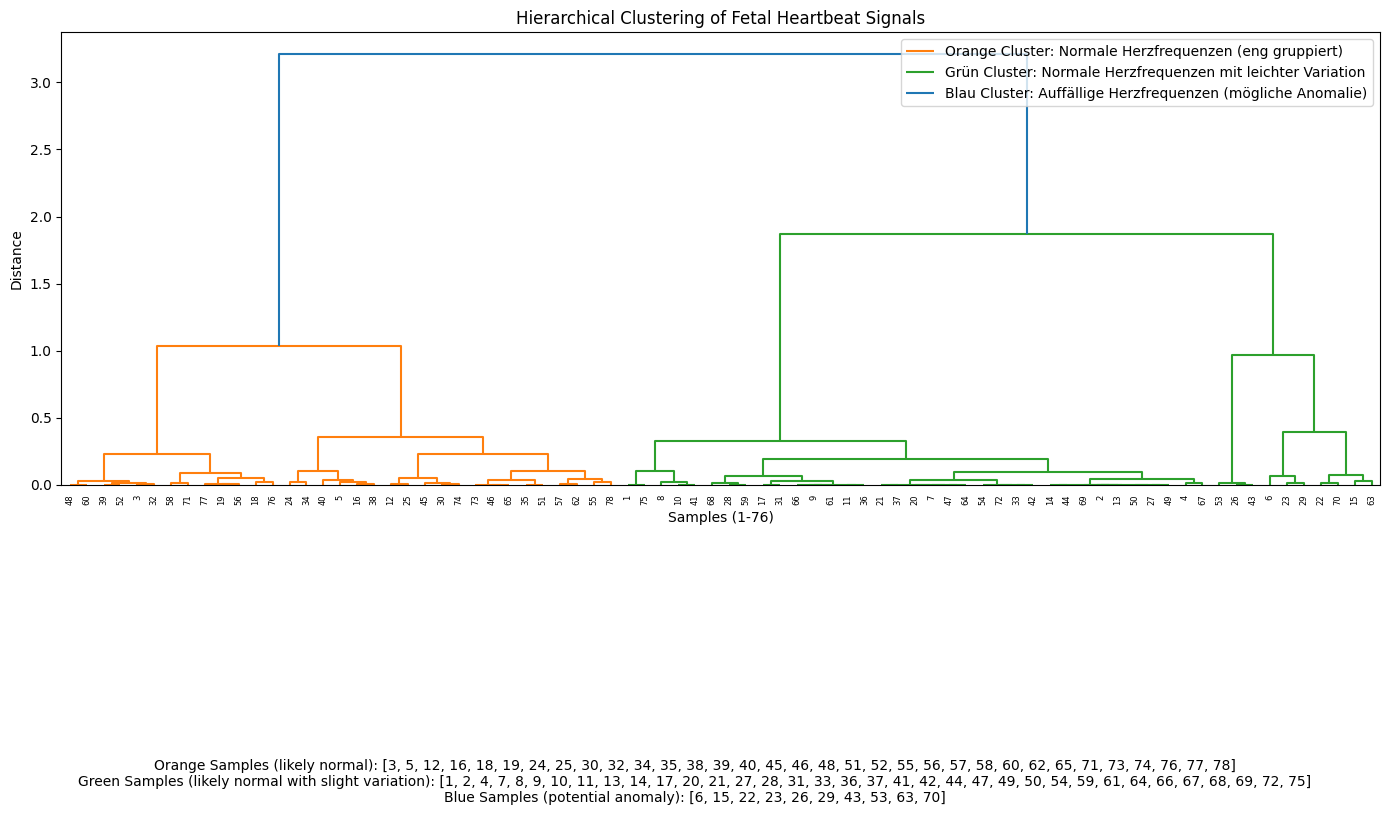

Sample 6 is in an anomalous cluster. Recommend further medical checkup.


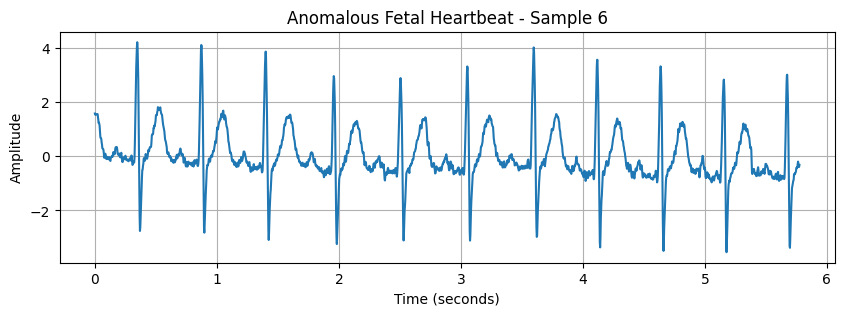

Sample 15 is in an anomalous cluster. Recommend further medical checkup.


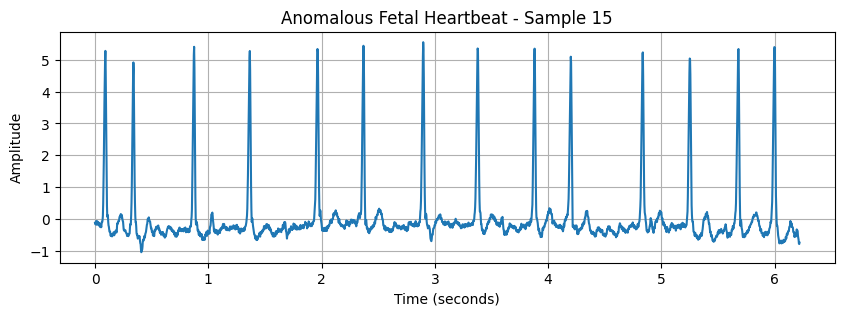

Sample 22 is in an anomalous cluster. Recommend further medical checkup.


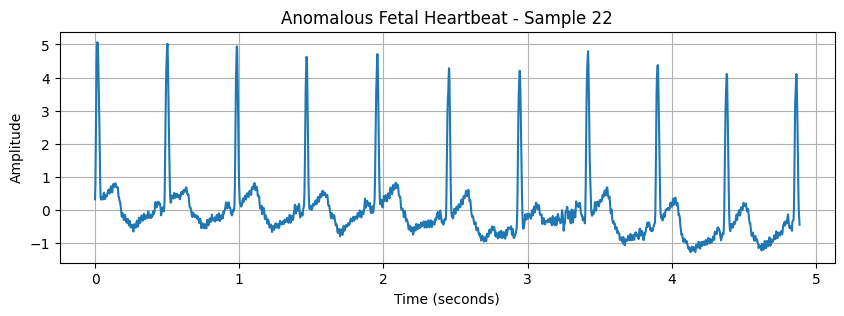

Sample 23 is in an anomalous cluster. Recommend further medical checkup.


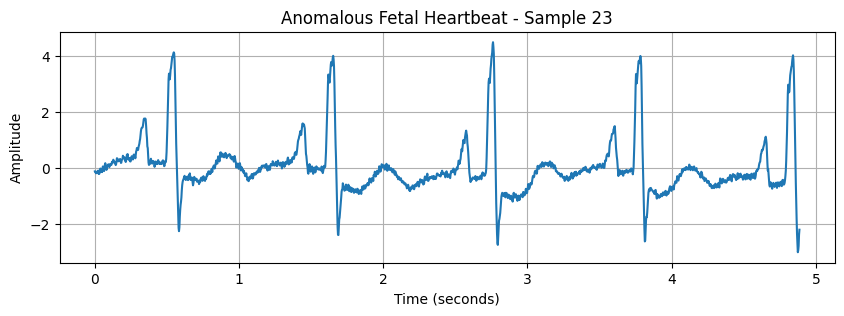

Sample 26 is in an anomalous cluster. Recommend further medical checkup.


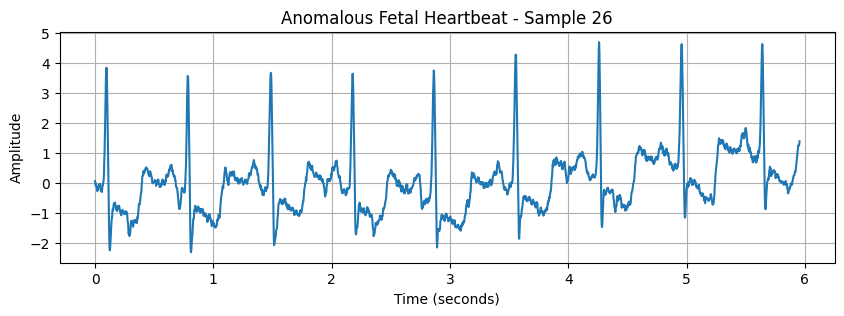

Sample 29 is in an anomalous cluster. Recommend further medical checkup.


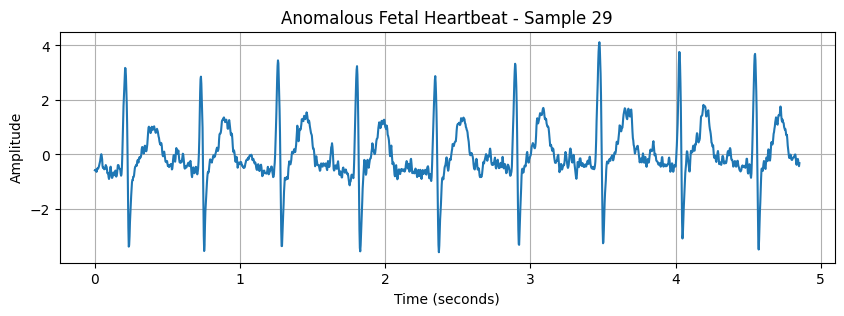

Sample 43 is in an anomalous cluster. Recommend further medical checkup.


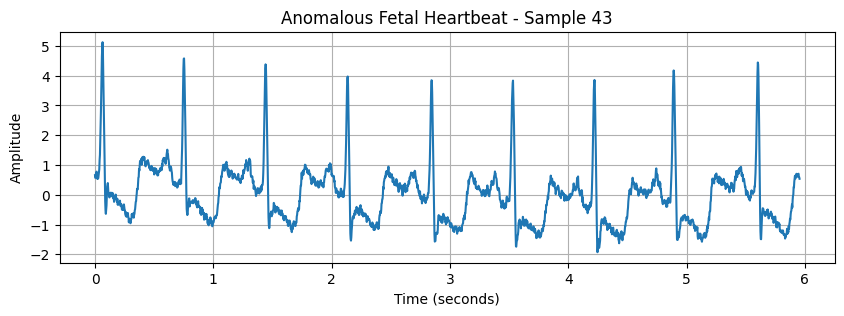

Sample 53 is in an anomalous cluster. Recommend further medical checkup.


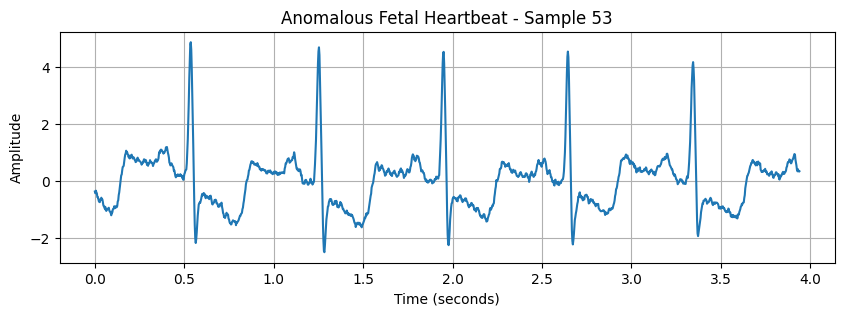

Sample 63 is in an anomalous cluster. Recommend further medical checkup.


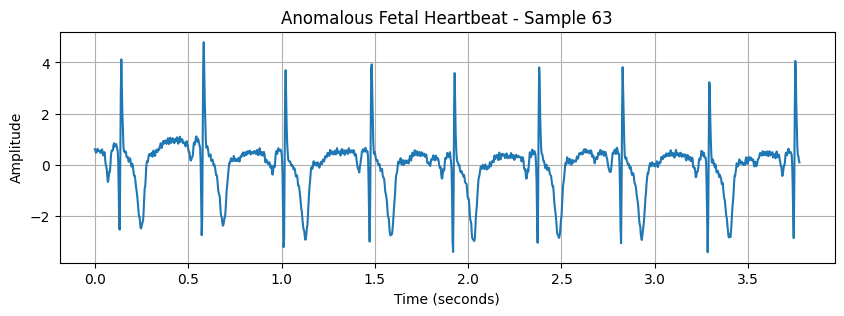

Sample 70 is in an anomalous cluster. Recommend further medical checkup.


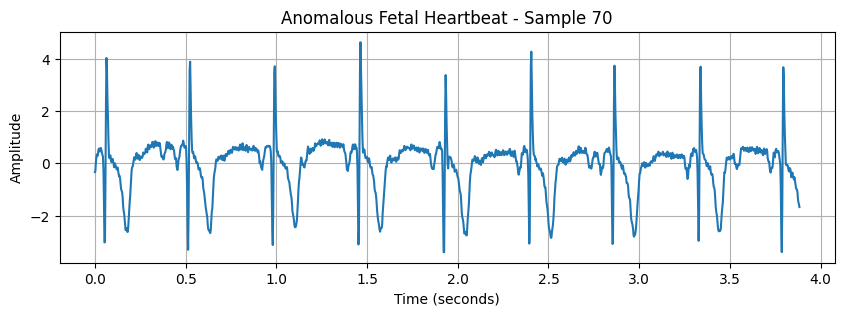

In [1]:
import numpy as np
import os
from scipy.io import loadmat
import matplotlib.pyplot as plt
from sklearn.decomposition import FastICA
from scipy.fft import fft, fftfreq
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

# Set the directory containing the .mat files
data_dir = 'heartbeat_data'
sr = 360  # Sampling rate for synthetic data

# Frequency ranges for maternal and fetal heartbeats
maternal_freq_range = (0.8, 2)  # Broadened maternal range in Hz
fetal_freq_range = (1.5, 3)     # Broadened fetal range in Hz

# Frequency analysis function to find dominant frequency
def analyze_frequency(signal, sr):
    N = len(signal)
    yf = fft(signal)
    xf = fftfreq(N, 1 / sr)
    positive_freqs = xf[:N // 2]  # Only positive frequencies
    positive_yf = np.abs(yf[:N // 2])  # Magnitude of FFT
    
    idx = np.argmax(positive_yf)
    dominant_freq = positive_freqs[idx]
    return dominant_freq

# Function to ensure signal has consistent polarity (positive peaks)
def ensure_positive_peaks(signal):
    if np.max(signal) < np.abs(np.min(signal)):
        return -signal  # Flip the signal to make peaks positive
    return signal

# Initialize lists to collect fetal heartbeat features (dominant frequencies) and signals
fetal_features = []
fetal_signals = []  # Store fetal signals for potential plotting

# Process each file in the directory
for filename in sorted(os.listdir(data_dir)):
    if filename.endswith('.mat'):
        file_path = os.path.join(data_dir, filename)
        
        # Load data
        data = loadmat(file_path)
        data_matrix = np.array([data['val'][0][i] for i in range(4)])  # shape (4, n_samples)
        data_matrix = data_matrix.T  # Transpose to (n_samples, n_channels)

        # Apply ICA
        ica = FastICA(n_components=4, random_state=0)
        components = ica.fit_transform(data_matrix)

        print(f"Processing file: {filename}")
        
        # Analyze each component and identify maternal and fetal heartbeat
        for i, component in enumerate(components.T):  # Transpose to get each component
            component = ensure_positive_peaks(component)
            
            # Calculate the dominant frequency
            dominant_freq = analyze_frequency(component, sr)
            if fetal_freq_range[0] <= dominant_freq <= fetal_freq_range[1]:
                label = "Fetal Heartbeat"
                fetal_features.append([dominant_freq])  # Add dominant frequency for clustering
                fetal_signals.append(component)  # Store the signal for potential plotting

# Convert fetal_features to a NumPy array for clustering
fetal_features = np.array(fetal_features)

# Apply hierarchical clustering using Ward's linkage
Z = linkage(fetal_features, method='ward')

# Plot the dendrogram
plt.figure(figsize=(14, 7))
dendrogram(
    Z,
    labels=[str(i+1) for i in range(len(fetal_features))],  # Labels are now just numbers 1-76
    orientation='top',
    leaf_rotation=90  # Rotate labels to be horizontal
)
plt.title("Hierarchical Clustering of Fetal Heartbeat Signals")
plt.xlabel("Samples (1-76)")
plt.ylabel("Distance")

# Define clusters based on colors (assuming visual inspection shows where to split)
max_distance = 1.5  # Adjust based on dendrogram structure
clusters = fcluster(Z, max_distance, criterion='distance')

# Separate sample indices by cluster color
orange_samples = [i+1 for i in range(len(clusters)) if clusters[i] == 1]
green_samples = [i+1 for i in range(len(clusters)) if clusters[i] == 2]
blue_samples = [i+1 for i in range(len(clusters)) if clusters[i] == 3]

# Adding a simple legend explaining clusters
plt.legend(["Orange Cluster: Normale Herzfrequenzen (eng gruppiert)", 
            "Grün Cluster: Normale Herzfrequenzen mit leichter Variation", 
            "Blau Cluster: Auffällige Herzfrequenzen (mögliche Anomalie)"], loc='upper right')


# Display summary of samples in each cluster below the plot
summary_text = (
    f"Orange Samples (likely normal): {orange_samples}\n"
    f"Green Samples (likely normal with slight variation): {green_samples}\n"
    f"Blue Samples (potential anomaly): {blue_samples}"
)
plt.figtext(0.5, -0.15, summary_text, wrap=True, horizontalalignment='center', fontsize=10)

plt.tight_layout()
plt.subplots_adjust(bottom=0.3)  # Adjusts the space for the summary text below the plot
plt.show()

# Step 6: Plot anomalous fetal heartbeats if they are in the blue cluster
anomalous_cluster_label = 3  # Assume the blue cluster is the anomalous cluster

for idx, (sample_index, signal) in enumerate(zip(range(1, len(fetal_signals) + 1), fetal_signals)):
    if clusters[idx] == anomalous_cluster_label:
        print(f"Sample {sample_index} is in an anomalous cluster. Recommend further medical checkup.")
        
        # Plot the fetal heartbeat signal for this anomalous sample
        plt.figure(figsize=(10, 3))
        plt.plot(np.arange(0, len(signal) / sr, 1 / sr), signal)
        plt.title(f"Anomalous Fetal Heartbeat - Sample {sample_index}")
        plt.xlabel("Time (seconds)")
        plt.ylabel("Amplitude")
        plt.grid()
        plt.show()
